## Scraping The Twitter Data

In [1]:
import GetOldTweets3 as got
import pandas as pd



In [2]:
tweetCriteria = got.manager.TweetCriteria().setUsername("realdonaldtrump").setSince("2017-01-20").setUntil("2020-06-05")
tweet = got.manager.TweetManager.getTweets(tweetCriteria)


In [3]:
tweet[0] #Each Tweet is stored as an object

In [4]:

data = {'id':[],'username':[],'date':[],'text':[], 'to':[], 'retweets':[],'favorites':[],'mentions':[],'hashtags':[]}
for i in tweet:
    data['id'].append(i.id)
    data['username'].append(i.username)
    data['date'].append(i.date)
    data['text'].append(i.text)
    data['to'].append(i.to)
    data['retweets'].append(i.retweets)
    data['favorites'].append(i.favorites)
    data['mentions'].append(i.mentions)
    data['hashtags'].append(i.hashtags)

In [5]:
df = pd.DataFrame(data)

df.to_csv('AllTrumpTweets.csv')

In [6]:
df.tail() #Tweets begin on Trump's inauguration to present day

,id,username,date,text,to,retweets,favorites,mentions,hashtags
11883,822501939267141634,realDonaldTrump,2017-01-20 17:51:58+00:00,"power from Washington, D.C. and giving it back...",realDonaldTrump,15458,80386,,#InaugurationDay
11884,822501803615014918,realDonaldTrump,2017-01-20 17:51:25+00:00,Today we are not merely transferring power fro...,None,17039,97333,,
11885,822421390125043713,realDonaldTrump,2017-01-20 12:31:53+00:00,It all begins today! I will see you at 11:00 A...,None,59696,238468,,
11886,822298747421986828,realDonaldTrump,2017-01-20 04:24:33+00:00,Thank you for a wonderful evening in Washingto...,None,17591,99734,,#Inauguration
11887,822242449053614081,realDonaldTrump,2017-01-20 00:40:51+00:00,Thank you for joining us at the Lincoln Memori...,None,29463,148540,,


## Insights

In [7]:
df = pd.read_csv('AllTrumpTweets.csv')

In [8]:
import matplotlib.pyplot as plt

#### Trump's most popular tweet during his presidency

In [9]:
df.loc[df['retweets'].idxmax()].text

'#FraudNewsCNN #FNN'

#### Trump's most frequent @ and hashtag

In [10]:
df.mentions.mode() #Trump clearly enjoys Fox news

0    @foxandfriends
dtype: object

In [11]:
df.hashtags.mode() #Obviously his catchy campaign slogan which makes sense

0    #MAGA
dtype: object

#### What month does Trump post the most during?

In [12]:
def getMonth(x):
    return x.split('-')[1]

In [13]:
df['month'] = df['date'].apply(getMonth)
df['month'] = df['month'].astype('int32')

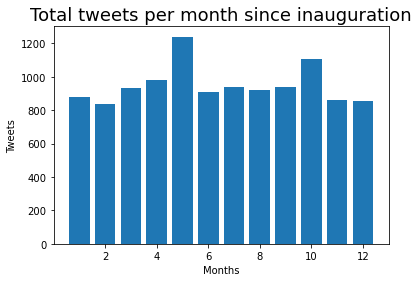

In [14]:
amounts = df.groupby('month').count()['text']
months = range(1,13)


plt.xticks = months
plt.xlabel('Months')
plt.ylabel('Tweets')
plt.title('Total tweets per month since inauguration', size=18)

plt.bar(months, amounts)
plt.show()
#Trump posted the most tweets during May since becoming president

#### On average how many tweets does Trump post per day?

In [15]:
def cutter(x):
    x = str(x)
    return x[:10]

In [16]:
df['newdate'] = df['date'].apply(cutter)

In [24]:
tweets_per_day = df.groupby('newdate').count()['Unnamed: 0']
tweets_per_day

newdate
2017-01-20    13
2017-01-21     2
2017-01-22     4
2017-01-23     1
2017-01-24     4
              ..
2020-05-31    12
2020-06-01     9
2020-06-02    30
2020-06-03    25
2020-06-04    44
Name: Unnamed: 0, Length: 1220, dtype: int64

In [25]:
#Most tweets per day
tweets_per_day.max()

44

In [26]:
#Average amount of tweets per day
tweets_per_day.mean()

9.744262295081967

#### Is there a correlation between the number of favourites and retweets?

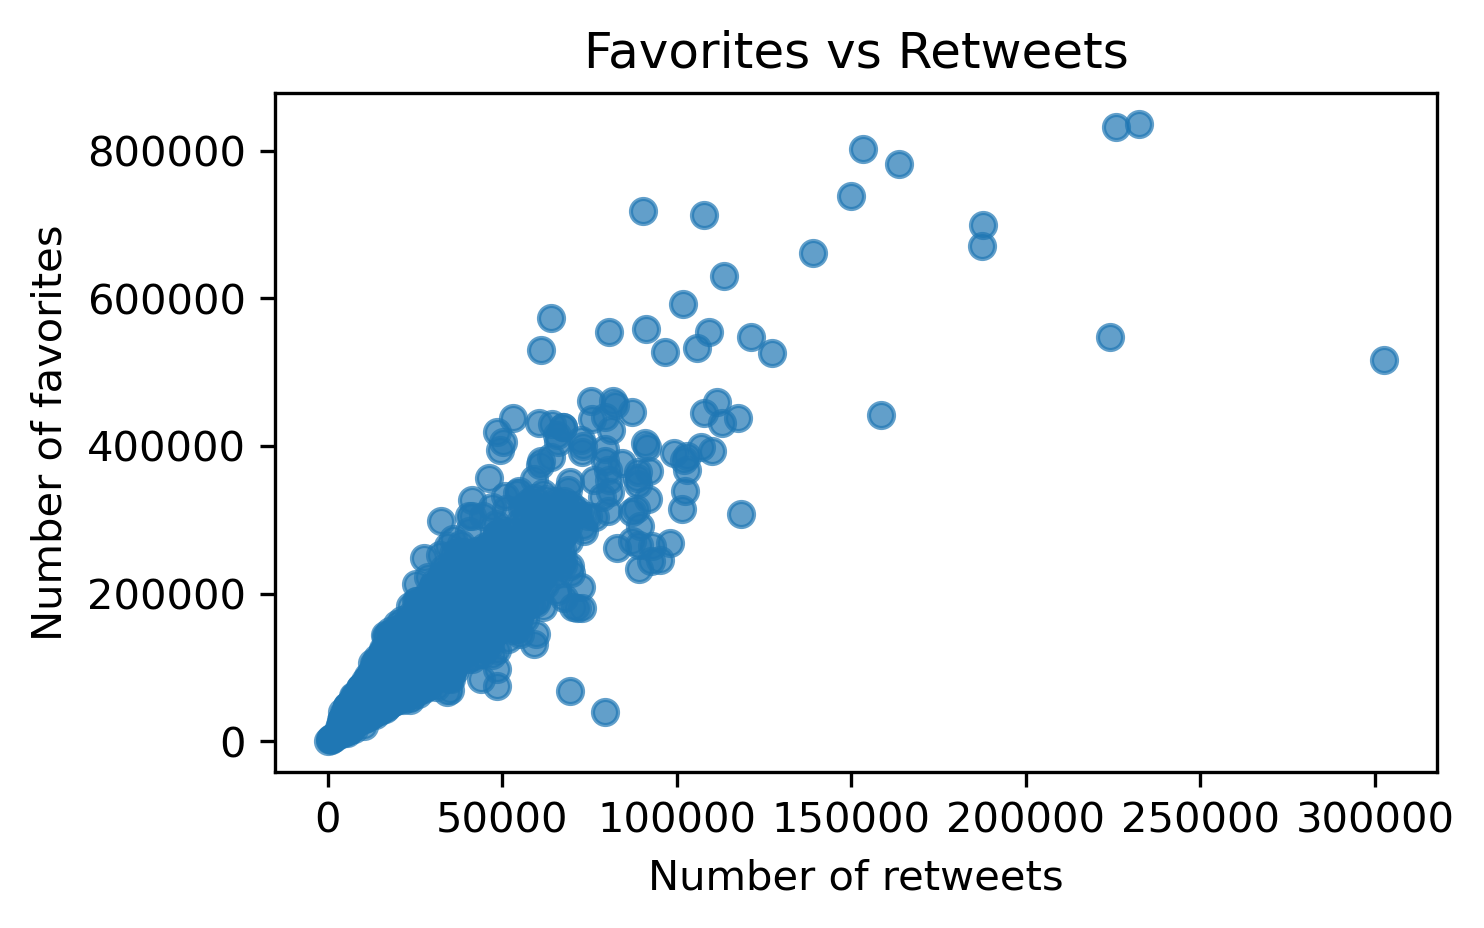

In [27]:
plt.figure(figsize=(5,3), dpi=300)
plt.scatter(df['retweets'],df['favorites'], alpha=.7)

plt.ylabel('Number of favorites')
plt.xlabel('Number of retweets')
plt.title("Favorites vs Retweets")

plt.show()
#There appears to exist a strong linear correlation between the two factors

In [28]:
df['retweets'].corr(df['favorites']) # 91% Correlated
#This makes sense since the more popular/retweeted a tweet, the more likes it has.

0.9175766849819944

#### Linear regression model for Favorites vs Retweets

In [29]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [30]:
x_train, x_test, y_train, y_test = train_test_split(df.retweets,df.favorites,test_size=0.33)

In [31]:
LR = LinearRegression()
LR.fit(x_train.values.reshape(-1,1),y_train.values)

LinearRegression()

In [32]:
prediction = LR.predict(x_test.values.reshape(-1,1))

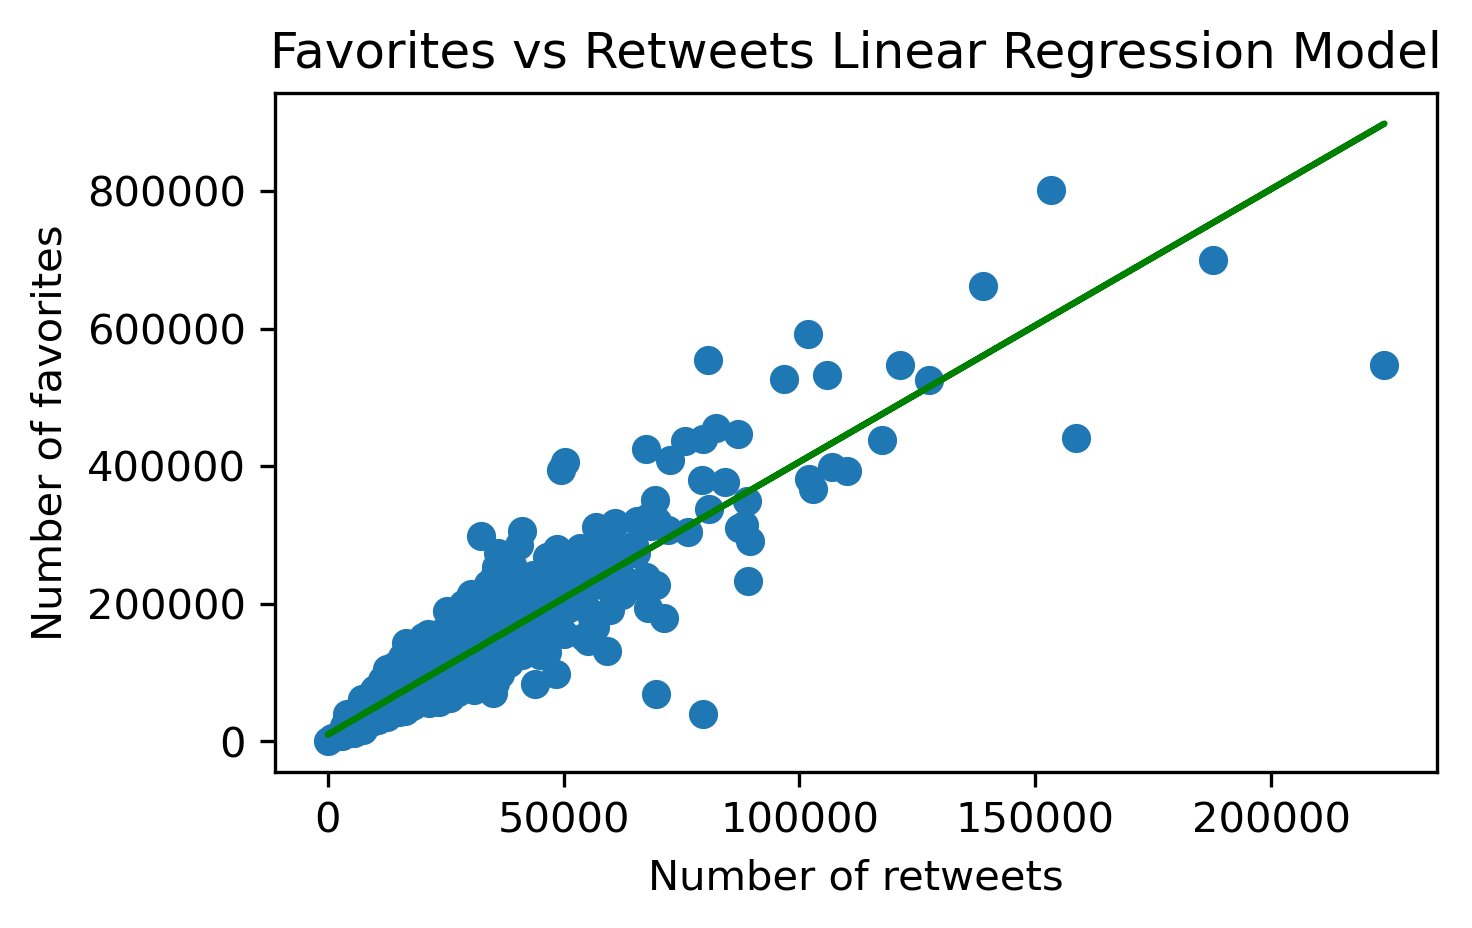

In [33]:
plt.figure(figsize=(5,3), dpi=300)
plt.plot(x_test,prediction, color = 'g')
plt.scatter(x_test,y_test)
plt.ylabel('Number of favorites')
plt.xlabel('Number of retweets')
plt.title("Favorites vs Retweets Linear Regression Model")
plt.show()

In [34]:
#Testing the model, input = 150,000 retweets, output = how many favorites?
LR.predict(np.array([[150000]]))[0]

604639.0120451007

In [35]:
#Model Performance Test
LR.score(x_test.values.reshape(-1,1),y_test.values)
#86% not bad

0.8556740293703726

## Natural Language Processing Sentiment Analysis

#### Cleaning the data


In [36]:
import re

def clean(x):
    x = str(x)
    regex = re.compile('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)')
    return regex.sub('', x)


In [37]:
df['newtext'] = df['text'].apply(clean)

In [38]:
df.rename(columns = {'Unnamed: 0':'index'}, inplace = True) 

#### Analysis

In [39]:
from textblob import TextBlob as tb

In [40]:
def sentiment_polarity(x):
    x = str(x)
    pol = tb(x).sentiment[0]    
    if pol > 0:
        return 'Positive'
    elif not(pol):
        return 'Neutral'
    else:
        return 'Negative'
    
def sentiment_subjectivity(x):
    x = str(x)
    sub = tb(x).sentiment[1]    
    if sub > 0.5:
        return 'Subjective'
    elif sub== 0.5:
        return 'Neutral'
    else:
        return 'Objective'

In [41]:
df['polarity'] = df['newtext'].apply(sentiment_polarity)
df['subjectivity'] = df['newtext'].apply(sentiment_subjectivity)

In [42]:
df.head()

,index,id,username,date,text,to,retweets,favorites,mentions,hashtags,month,newdate,newtext,polarity,subjectivity
0,0,1268688014630322177,realDonaldTrump,2020-06-04 23:36:08+00:00,"...Unrelated, I gave Alaska ANWR, major highwa...",NaN,18369,81483,NaN,NaN,6,2020-06-04,Unrelated I gave Alaska ANWR major highways an...,Positive,Subjective
1,1,1268688013791506450,realDonaldTrump,2020-06-04 23:36:08+00:00,Few people know where they’ll be in two years ...,NaN,32744,140027,NaN,NaN,6,2020-06-04,Few people know where theyll be in two years f...,Positive,Objective
2,2,1268686977320263681,realDonaldTrump,2020-06-04 23:32:01+00:00,“Police Groups Break With Biden” @politico His...,NaN,31658,125585,@politico,NaN,6,2020-06-04,Police Groups Break With Biden His handlers w...,Positive,Neutral
3,3,1268685511755026432,realDonaldTrump,2020-06-04 23:26:11+00:00,Great to be with our wonderful Men and Women o...,NaN,25091,101155,@SecretService,NaN,6,2020-06-04,Great to be with our wonderful Men and Women o...,Positive,Subjective
4,4,1268684040334446593,realDonaldTrump,2020-06-04 23:20:20+00:00,The problem with asking for someone to give yo...,NaN,25302,113529,NaN,NaN,6,2020-06-04,The problem with asking for someone to give yo...,Negative,Objective


#### Visualizing Trump's overall sentiment

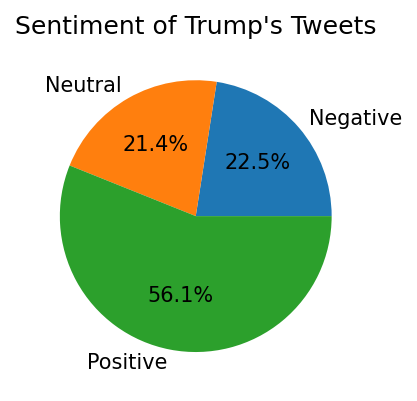

In [43]:
positive = df.groupby('polarity').count()
values = dict(positive['index'])
plt.figure(figsize=(5,3), dpi=150)
plt.title("Sentiment of Trump's Tweets")
plt.pie(values.values(), labels=values.keys(),autopct='%1.1f%%')
plt.show()

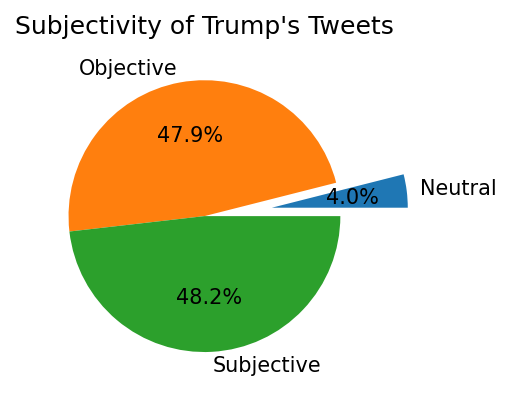

In [44]:
subj = df.groupby('subjectivity').count()
subj_values = dict(subj['index'])
plt.figure(figsize=(5,3), dpi=150)
explode = (0.5, 0, 0)
plt.title("Subjectivity of Trump's Tweets")
plt.pie(subj_values.values(),explode=explode, labels=subj_values.keys(),autopct='%1.1f%%')
plt.show()

#### Correlation between Trump's tweets and the stock market
#### Hypothesis: Bullish days will have Positive Tweets, Bearish Days, Negative ones

In [105]:
dowjones = pd.read_csv('dowjones.csv')
dowjones.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-23,19794.789063,19833.980469,19732.359375,19799.849609,19799.849609,326690000
1,2017-01-24,19794.679688,19949.240234,19786.710938,19912.710938,19912.710938,374460000
2,2017-01-25,19994.480469,20082.000000,19994.480469,20068.509766,20068.509766,372240000
3,2017-01-26,20076.250000,20125.580078,20067.529297,20100.910156,20100.910156,356730000
4,2017-01-27,20103.359375,20115.970703,20072.640625,20093.779297,20093.779297,343130000


In [106]:
dowjones['Net'] = dowjones['Close'] - dowjones['Open']
dowjones['Net'] = dowjones['Net'].apply(int)


In [121]:
#Filtering out days where the dow was ranging
dowjones.loc[dowjones['Close'] - dowjones['Open'] > 100, 'NetValue'] = 'Gain'
dowjones.loc[dowjones['Close'] - dowjones['Open'] < -100, 'NetValue'] = 'Loss'
dowjones = dowjones.dropna()
dowjones.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Net,NetValue
1,2017-01-24,19794.679688,19949.240234,19786.710938,19912.710938,19912.710938,374460000,118,Gain
9,2017-02-03,19964.210938,20081.480469,19964.210938,20071.460938,20071.460938,344220000,107,Gain
13,2017-02-09,20061.730469,20206.359375,20061.730469,20172.400391,20172.400391,325310000,110,Gain
16,2017-02-14,20374.220703,20504.410156,20374.019531,20504.410156,20504.410156,356580000,130,Gain
17,2017-02-15,20504.269531,20620.449219,20496.029297,20611.859375,20611.859375,384380000,107,Gain


In [122]:
def getscore(x):
    x=str(x)
    return tb(x).sentiment[0]

In [123]:
df['score'] = df['newtext'].apply(getscore)
df.head()

,index,id,username,date,text,to,retweets,favorites,mentions,hashtags,month,newdate,newtext,polarity,subjectivity,score,weekday
0,0,1268688014630322177,realDonaldTrump,2020-06-04 23:36:08+00:00,"...Unrelated, I gave Alaska ANWR, major highwa...",NaN,18369,81483,NaN,NaN,6,2020-06-04,Unrelated I gave Alaska ANWR major highways an...,Positive,Subjective,0.152500,yes
1,1,1268688013791506450,realDonaldTrump,2020-06-04 23:36:08+00:00,Few people know where they’ll be in two years ...,NaN,32744,140027,NaN,NaN,6,2020-06-04,Few people know where theyll be in two years f...,Positive,Objective,0.325000,yes
2,2,1268686977320263681,realDonaldTrump,2020-06-04 23:32:01+00:00,“Police Groups Break With Biden” @politico His...,NaN,31658,125585,@politico,NaN,6,2020-06-04,Police Groups Break With Biden His handlers w...,Positive,Neutral,0.500000,yes
3,3,1268685511755026432,realDonaldTrump,2020-06-04 23:26:11+00:00,Great to be with our wonderful Men and Women o...,NaN,25091,101155,@SecretService,NaN,6,2020-06-04,Great to be with our wonderful Men and Women o...,Positive,Subjective,0.900000,yes
4,4,1268684040334446593,realDonaldTrump,2020-06-04 23:20:20+00:00,The problem with asking for someone to give yo...,NaN,25302,113529,NaN,NaN,6,2020-06-04,The problem with asking for someone to give yo...,Negative,Objective,-0.266667,yes


In [124]:
scores_per_day = df.groupby('newdate').sum()['score']
#Getting sentiment scores for each day

##### Obtained the scores for each day, however, the prices of the dow jones index are only for weekdays, so all weekend scores must be removed before further comparison.

In [125]:
import datetime
from dateutil import parser

In [126]:
def is_it_weekday(x):
    #Determines if the date passed in is a weekday or a weekend
    x = str(x)
    a = parser.parse(x)
    b = a.weekday()
    
    if b in [i for i in range(0,5)]:
        return "yes"
    return "no"

In [127]:
df['weekday'] = df['newdate'].apply(is_it_weekday)

In [128]:
#Filtering out weekend tweet scores
newDF = df.copy()
newDF = newDF[~newDF.weekday.str.contains("no")]
newDF.head()

,index,id,username,date,text,to,retweets,favorites,mentions,hashtags,month,newdate,newtext,polarity,subjectivity,score,weekday
0,0,1268688014630322177,realDonaldTrump,2020-06-04 23:36:08+00:00,"...Unrelated, I gave Alaska ANWR, major highwa...",NaN,18369,81483,NaN,NaN,6,2020-06-04,Unrelated I gave Alaska ANWR major highways an...,Positive,Subjective,0.152500,yes
1,1,1268688013791506450,realDonaldTrump,2020-06-04 23:36:08+00:00,Few people know where they’ll be in two years ...,NaN,32744,140027,NaN,NaN,6,2020-06-04,Few people know where theyll be in two years f...,Positive,Objective,0.325000,yes
2,2,1268686977320263681,realDonaldTrump,2020-06-04 23:32:01+00:00,“Police Groups Break With Biden” @politico His...,NaN,31658,125585,@politico,NaN,6,2020-06-04,Police Groups Break With Biden His handlers w...,Positive,Neutral,0.500000,yes
3,3,1268685511755026432,realDonaldTrump,2020-06-04 23:26:11+00:00,Great to be with our wonderful Men and Women o...,NaN,25091,101155,@SecretService,NaN,6,2020-06-04,Great to be with our wonderful Men and Women o...,Positive,Subjective,0.900000,yes
4,4,1268684040334446593,realDonaldTrump,2020-06-04 23:20:20+00:00,The problem with asking for someone to give yo...,NaN,25302,113529,NaN,NaN,6,2020-06-04,The problem with asking for someone to give yo...,Negative,Objective,-0.266667,yes


#### Filtering for tweets which would have most impact on economy

In [129]:

words = ['economy','taxes','tax','economic','china', 'jobs','xi','tarrifs','FED','inflation','trade','rates','currency','dow','gdp','income','production']

impact_tweets = pd.DataFrame()

for i in words:
    tempDF = newDF[newDF["newtext"].str.contains(i) == True]
    impact_tweets = pd.concat([impact_tweets,tempDF])


impact_tweets = impact_tweets.drop_duplicates(keep='first')

In [141]:
impact_tweets_dict = dict(impact_tweets.groupby('newdate').sum()['score'])

In [142]:
def newSentiment(x):
    if x>0:
        return 'Positive'
    elif x<0:
        return 'Negative'
    return 'Neutral'

#Formating new Dataframe for easier analysis
comparison = pd.DataFrame(columns = ['Date', 'Score','Net'])
comparison['Date'] = impact_tweets_dict.keys()
comparison['ScoreValue'] = impact_tweets_dict.values()
comparison['Score'] = {k: newSentiment(v) for k, v in impact_tweets_dict.items()}.values()

comparison.loc[comparison.Date.isin(dowjones.Date), ['Net']] = dowjones[['Net']]
comparison.dropna(subset = ["Net"], inplace=True)
comparison

,Date,Score,Net,ScoreValue
45,2017-06-29,Positive,159,0.373712
90,2017-10-25,Positive,113,0.628333
110,2017-12-14,Positive,-200,0.505195
139,2018-02-20,Positive,-144,0.782273
144,2018-03-05,Positive,-234,0.430909
...,...,...,...,...
508,2020-05-12,Positive,188,0.365714
511,2020-05-18,Negative,177,-0.223611
512,2020-05-19,Positive,123,1.000000
517,2020-05-26,Positive,273,0.364889


In [154]:
comparison.loc[comparison['Net'] > 0, 'NetValue'] = 'Gain'
comparison.loc[comparison['Net'] < 0, 'NetValue'] = 'Loss'
comparison

,Date,Score,Net,ScoreValue,NetValue
45,2017-06-29,Positive,159,0.373712,Gain
90,2017-10-25,Positive,113,0.628333,Gain
110,2017-12-14,Positive,-200,0.505195,Loss
139,2018-02-20,Positive,-144,0.782273,Loss
144,2018-03-05,Positive,-234,0.430909,Loss
...,...,...,...,...,...
508,2020-05-12,Positive,188,0.365714,Gain
511,2020-05-18,Negative,177,-0.223611,Gain
512,2020-05-19,Positive,123,1.000000,Gain
517,2020-05-26,Positive,273,0.364889,Gain


In [144]:
comparison.groupby(['NetValue','Score']).count()

Date  Net  ScoreValue
NetValue Score                          
Gain     Negative     9    9           9
         Neutral      2    2           2
         Positive    39   39          39
Loss     Negative    11   11          11
         Neutral      2    2           2
         Positive    32   32          32

### It appears as though if an average distribution is taken, overall sentiment is the same for gain days and loss days. This could be attributed to the fact that the Natural Language Processing model was misinterpreting economic language, for instance, high taxes would be classified as 'Positive' even though it has a negative impact on the economy/stock market.

In [159]:
tb("High taxes").sentiment[0] 
#An example of the NLP model's poor identification of economic sentiment

0.16

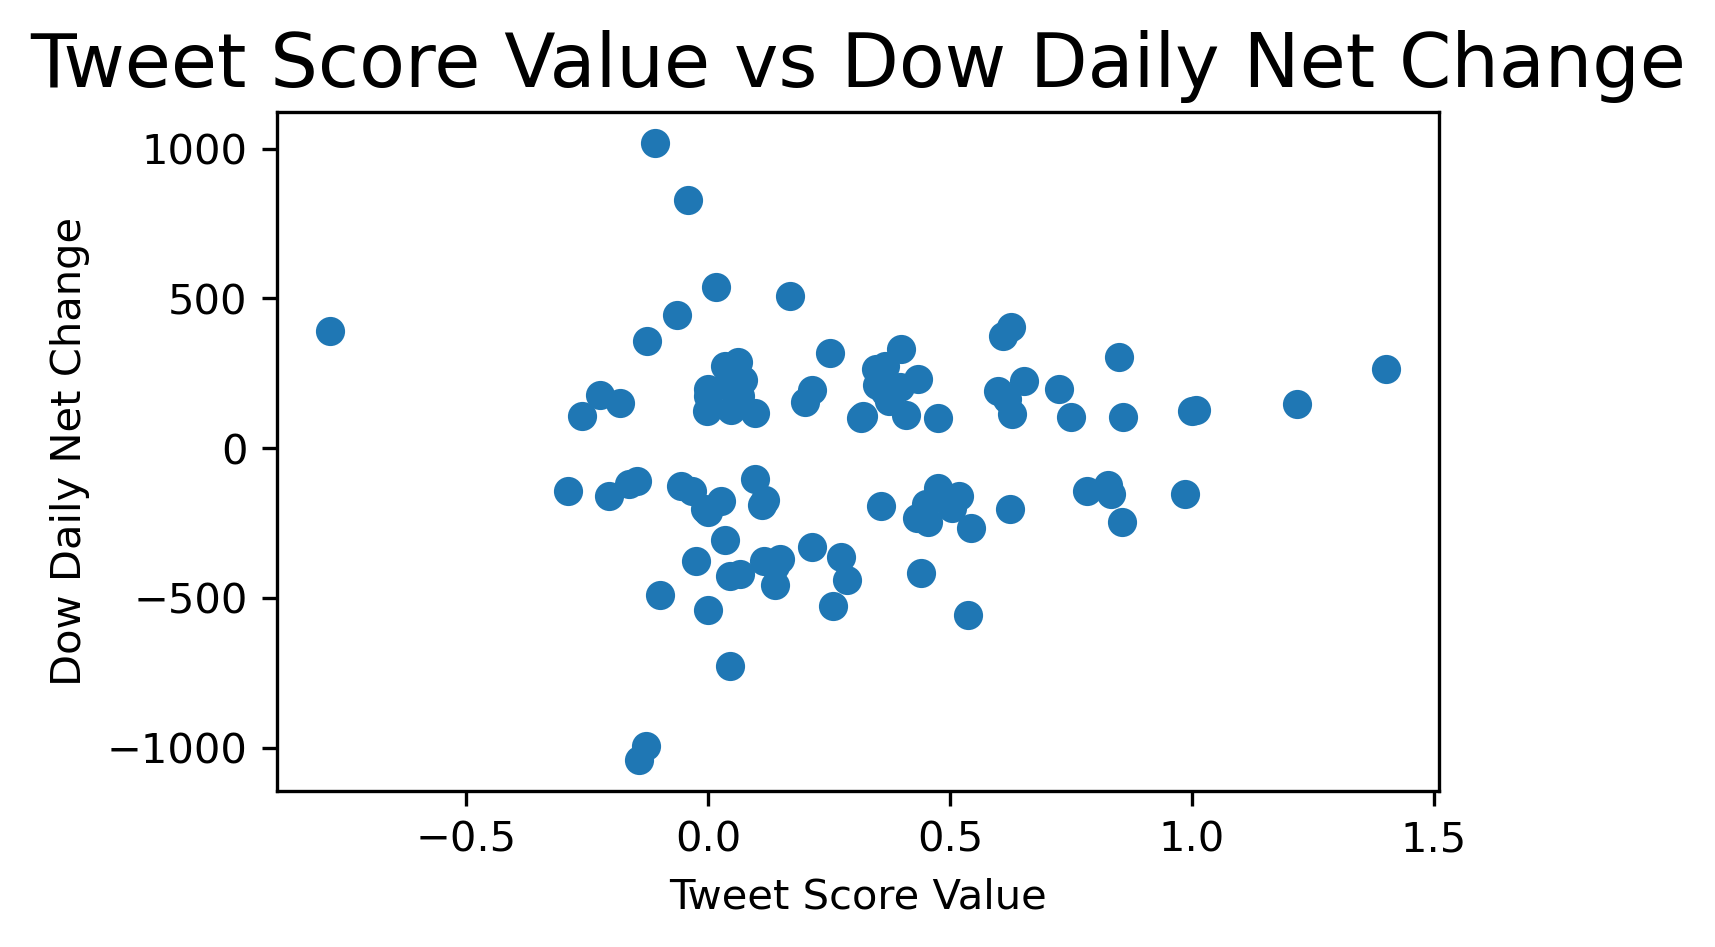

In [283]:
plt.figure(figsize=(5,3), dpi=300)
plt.title("Tweet Score Value vs Dow Daily Net Change", size = 18)
plt.xlabel('Tweet Score Value')
plt.ylabel('Dow Daily Net Change')
plt.scatter(comparison.ScoreValue,comparison.Net)

plt.show()

### The above model takes magnitude into account. It appears as though the NLP model was overclassifying and misclassifying tweets as positive.

In [278]:
newcomparison = comparison.loc[(comparison.ScoreValue > 0.5)]

In [279]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(newcomparison.ScoreValue,newcomparison.Net,test_size=0.1)

In [280]:
LR2 = LinearRegression()
LR.fit(x_train2.values.reshape(-1,1),y_train2.values)

LinearRegression()

In [281]:
prediction2 = LR.predict(x_test2.values.reshape(-1,1))

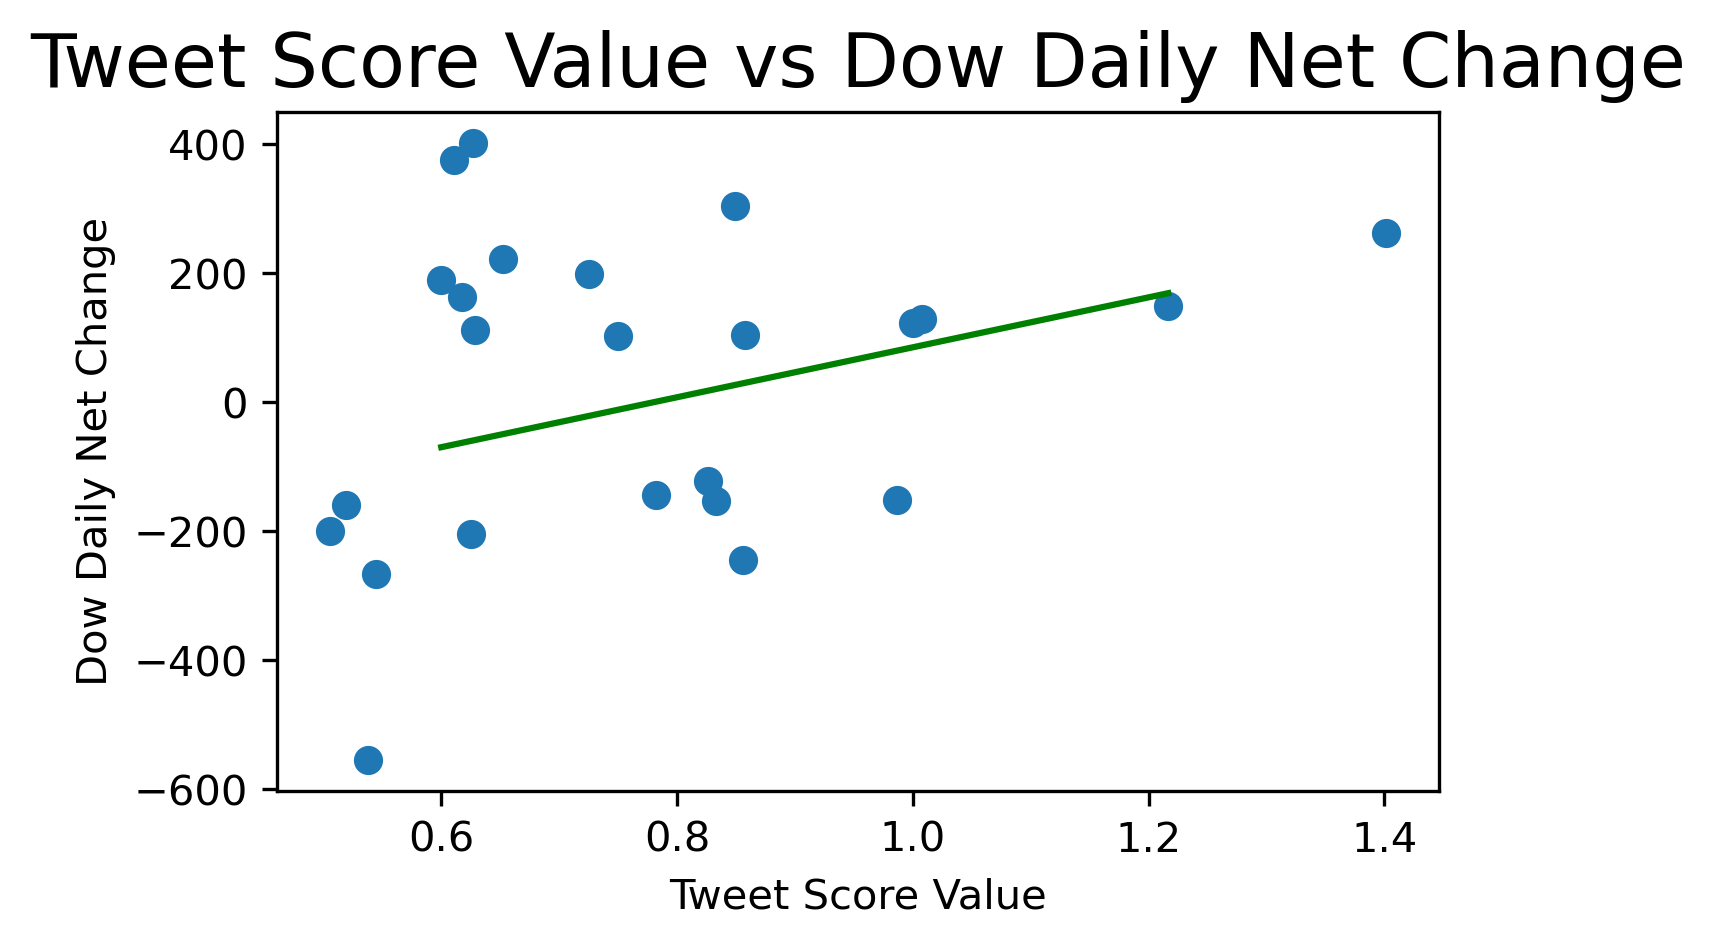

In [282]:
plt.figure(figsize=(5,3), dpi=300)
plt.title("Tweet Score Value vs Dow Daily Net Change", size = 18)
plt.xlabel('Tweet Score Value')
plt.ylabel('Dow Daily Net Change')
plt.scatter(newcomparison.ScoreValue,newcomparison.Net)
plt.plot(x_test2,prediction2, color = 'g')

plt.show()

### With the assumption that the model could only somewhat classify positive tweets, if only tweets with a very positive sentiment are used (>0.5) a very weak trend can be seen based on the LR model, however more data would obviously be required to call this an actual "trend".

### Overall it can be concluded that although Trump's tweets have impacted the financial markets in the past, a basic NLP model would not be adequate to measure this correlation. This basic model would not be an accurate way to predict dow jones stock swings.